## Example two - character level sequence to sequence prediction
Tutorial [How to use Keras sparse_categorical_crossentropy](https://www.dlology.com/blog/how-to-use-keras-sparse_categorical_crossentropy/)

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Predict Shakespeare with Keras

This example uses [tf.keras](https://www.tensorflow.org/guide/keras) to build a *language model* and train it on a GPU. This language model predicts the next character of text given the text so far. The trained model can generate new snippets of text that read in a similar style to the text training data.

We'll train the model on the combined works of William Shakespeare, then use it to compose a play in the style of *The Great Bard*:

<blockquote>
Loves that led me no dumbs lack her Berjoy's face with her to-day.  
The spirits roar'd; which shames which within his powers  
	Which tied up remedies lending with occasion,  
A loud and Lancaster, stabb'd in me  
	Upon my sword for ever: 'Agripo'er, his days let me free.  
	Stop it of that word, be so: at Lear,  
	When I did profess the hour-stranger for my life,  
	When I did sink to be cried how for aught;  
	Some beds which seeks chaste senses prove burning;  
But he perforces seen in her eyes so fast;  
And _  
</blockquote>


## Download data

Download *The Complete Works of William Shakespeare* as a single text file from [Project Gutenberg](https://www.gutenberg.org/). We'll use snippets from this file as the *training data* for the model. The *target* snippet is offset by one character.

In [2]:
# !wget --show-progress --continue -O data/shakespeare.txt http://www.gutenberg.org/files/100/100-0.txt

### Build the data generator

In [3]:
import numpy as np
import six
import tensorflow as tf
import time
import os

SHAKESPEARE_TXT = 'data/shakespeare.txt'

tf.logging.set_verbosity(tf.logging.INFO)

def transform(txt, pad_to=None):
    """
    Transform chars in txt to ascii values np.array, drop non-ascii chars.
    """
    # drop any non-ascii characters
    output = np.asarray([ord(c) for c in txt if ord(c) < 255], dtype=np.int32)
    if pad_to is not None:
        output = output[:pad_to]
        output = np.concatenate([
            np.zeros([pad_to - len(txt)], dtype=np.int32),
            output,
        ])
    return output

def training_generator(seq_len=100, batch_size=1024):
    """A generator yields (source, target) arrays for training."""
    with tf.gfile.GFile(SHAKESPEARE_TXT, 'r') as f:
        txt = f.read()

    tf.logging.info('Input text [%d] %s', len(txt), txt[:50])
    source = transform(txt)
    while True:
        # One batch of offsets for sampling sequences randomly.
        offsets = np.random.randint(low=0, high=len(source) - seq_len, size=batch_size)

        # Our model uses sparse crossentropy loss, but Keras requires labels
        # to have the same rank as the input logits.  We add an empty final
        # dimension to account for this.
        yield (
            np.stack([source[idx:idx + seq_len] for idx in offsets]),
            np.expand_dims(
                np.stack([source[idx + 1:idx + seq_len + 1] for idx in offsets]),
                -1),
        )

x, y = six.next(training_generator(seq_len=10, batch_size=2))
print('x, shape:', x.shape, ', x:', x)
print('y, shape:', y.shape, ', y:', y)

c:\users\hasee\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:tensorflow:Input text [5834393] ﻿
Project Gutenberg’s The Complete Works of Willi
x, shape: (2, 10) , x: [[109 109 117 110 105  99  97 116  39 115]
 [114 101  32  97 110 103 114 121  13  10]]
y, shape: (2, 10, 1) , y: [[[109]
  [117]
  [110]
  [105]
  [ 99]
  [ 97]
  [116]
  [ 39]
  [115]
  [116]]

 [[101]
  [ 32]
  [ 97]
  [110]
  [103]
  [114]
  [121]
  [ 13]
  [ 10]
  [ 32]]]


In [4]:
transform('123 bc ABC')

array([49, 50, 51, 32, 98, 99, 32, 65, 66, 67])

## Build the model

The model is defined as a two-layer, forward-LSTM—with two changes from the `tf.keras` standard LSTM definition:

1. Define the input `shape` of our model which satisfies the [XLA compiler](https://www.tensorflow.org/performance/xla/)'s static shape requirement.
2. Use `tf.train.Optimizer` instead of a standard Keras optimizer (Keras optimizer support is still experimental).

By using `sparse_categorical_crossentropy` we can have keep integer as chars' labels without transforming to one-hot labels.
So the output of the model will be in softmaxed one-hot like shape while the labels are integers.

In [5]:
EMBEDDING_DIM = 512
MAX_TOKENS = 256
def lstm_model(seq_len=100, batch_size=None, stateful=True, max_tokens = 256):
    """Language model: predict the next char given the current char."""
    source = tf.keras.Input(
        name='seed', shape=(seq_len,), batch_size=batch_size, dtype=tf.int32)

    embedding = tf.keras.layers.Embedding(input_dim=max_tokens, output_dim=EMBEDDING_DIM)(source)
    lstm_1 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(embedding)
    lstm_2 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(lstm_1)
    predicted_char = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(max_tokens, activation='softmax'))(lstm_2)
    model = tf.keras.Model(inputs=[source], outputs=[predicted_char])
    model.compile(
        optimizer=tf.train.RMSPropOptimizer(learning_rate=0.01),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])
    return model

## Train the model

The `tf.contrib.tpu.keras_to_tpu_model` function converts a `tf.keras` model to an equivalent TPU version. We then use the standard Keras methods to train: `fit`, `predict`, and `evaluate`.

In [6]:
tf.keras.backend.clear_session()

training_model = lstm_model(seq_len=100, batch_size=128, stateful=False, max_tokens = MAX_TOKENS)

# tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#     training_model,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

training_model.summary()

training_model.fit_generator(
    training_generator(seq_len=100, batch_size=128),
    steps_per_epoch=100,
    epochs=2, # 10
)
training_model.save_weights('models/bard-GPU-epoch2.h5', overwrite=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seed (InputLayer)            (128, 100)                0         
_________________________________________________________________
embedding (Embedding)        (128, 100, 512)           131072    
_________________________________________________________________
lstm (LSTM)                  (128, 100, 512)           2099200   
_________________________________________________________________
lstm_1 (LSTM)                (128, 100, 512)           2099200   
_________________________________________________________________
time_distributed (TimeDistri (128, 100, 256)           131328    
Total params: 4,460,800
Trainable params: 4,460,800
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
INFO:tensorflow:Input text [5834393] ﻿
Project Gutenberg’s The Complete Works of Willi
100/100 [==========================

## Make predictions with the model

Use the trained model to make predictions and generate your own Shakespeare-esque play.
Start the model off with a *seed* sentence, then generate 250 characters from it. We'll make five predictions from the initial seed.

In [6]:
BATCH_SIZE = 5
PREDICT_LEN = 250

# Keras requires the batch size be specified ahead of time for stateful models.
# We use a sequence length of 1, as we will be feeding in one character at a 
# time and predicting the next character.
prediction_model = lstm_model(seq_len=1, batch_size=BATCH_SIZE, stateful=True, max_tokens = MAX_TOKENS)
prediction_model.load_weights('models/bard-GPU-epoch2.h5') # bard-TPU-epoch10.h5 or bard-GPU-epoch2.h5

# We seed the model with our initial string, copied BATCH_SIZE times

seed_txt = 'Looks it not like the king?  Verily, we must go! '

# Text chars to ascii values np.array.
seed = transform(seed_txt)

# Repeat seed for batch size times.
seed = np.repeat(np.expand_dims(seed, 0), BATCH_SIZE, axis=0)

prediction_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seed (InputLayer)            (5, 1)                    0         
_________________________________________________________________
embedding (Embedding)        (5, 1, 512)               131072    
_________________________________________________________________
lstm (LSTM)                  (5, 1, 512)               2099200   
_________________________________________________________________
lstm_1 (LSTM)                (5, 1, 512)               2099200   
_________________________________________________________________
time_distributed (TimeDistri (5, 1, 256)               131328    
Total params: 4,460,800
Trainable params: 4,460,800
Non-trainable params: 0
_________________________________________________________________


In [7]:
# First, run the seed forward to prime the state of the model.
prediction_model.reset_states()

# Kick start with the seed text.
for i in range(len(seed_txt) - 1):
    prediction_model.predict(seed[:, i:i + 1])

In [8]:
predictions = [seed[:, -1:]]
predictions[-1].shape

(5, 1)

In [9]:
# Last chars in the batch
last_char = predictions[-1]
# Predict with only the last chars as input
next_probits = prediction_model.predict(last_char)[:, 0, :]

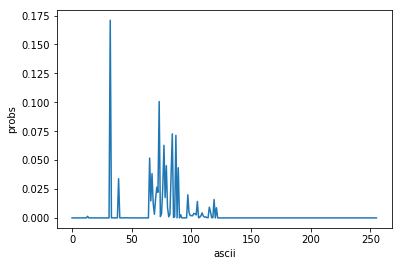

In [10]:
import matplotlib.pyplot as plt
plt.plot(next_probits[1])
plt.xlabel('ascii')
plt.ylabel('probs')
plt.show()

In [11]:
# Now we can accumulate predictions!

# The last char's ascii value for each sequence in seed batch (5 sequences).
predictions = [seed[:, -1]]

# Predict PREDICT_LEN(250) in number of chars.
for i in range(PREDICT_LEN):
    # Last chars in the batch
    last_char = predictions[-1]
    
    # Predict with only the last chars as inputs.
    next_probits = prediction_model.predict(last_char)[:, 0, :]

    # Sample from output distribution for each sample in the batch.
    next_idx = [
        np.random.choice(len(next_probits[0]), p=next_probits[i])
        for i in range(BATCH_SIZE)
    ]
    # Collect the sampled output char ascii values.
    predictions.append(np.asarray(next_idx, dtype=np.int32))


## Create new scripts
For better performance, either train for more epochs or download the pre-trained weigths [bard-TPU-epoch10.h5](https://github.com/Tony607/keras_sparse_categorical_crossentropy/releases/download/V0.1/bard-TPU-epoch10.h5) and copy over to `./models` directory.

In [12]:
# For each batch, ascii values -> chars.
for i in range(BATCH_SIZE):
    print('PREDICTION %d\n\n' % i)
    p = [predictions[j][i] for j in range(PREDICT_LEN)]
    generated = ''.join([chr(c) for c in p])
    print(generated)
    print()
    assert len(generated) == PREDICT_LEN, 'Generated text too short'

PREDICTION 0


       Exit
  PETER. Most fly with her?

                    Re-enter the Colcertal
  SALERIO, Servants, countenance and Bon to Goneril.
  SHEPHERD. So should I have forsworn: and follow him dowrier, and he
    Life against whom thy last consen

PREDICTION 1


      [Flourish] Enter, one
  FORD. No, neither?
  CONSPERS. Madam, and in me, call I warrant you!
  PROSPERO. Fesperas, you note; et a foul King;
    And from the sun nor the excellent good.
    Your fair dotages in arms;
    For my verses, wh

PREDICTION 2


        Exeunt COMERIUS
    He is gordeity?
  MICHAEL. I dare not torture, measure.
  VIOLA. Rerlain, how was not the fiend?
  SOMERSET. Give me the humours, coming for this:
Ha! Would I send love memorizo? when one one farewele to see below,
H

PREDICTION 3


     552

As one more but that from him-followers,
Ohlelly consents and vows of all
enemies love as you know me.

PRINCE.
Not what you are sick; unto the people, and good heart
in men, do well example. 

### To run the code with TPU on Colab

<table class="tfo-notebook-buttons" align="left">
 <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/shakespeare_with_tpu_and_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tpu/blob/master/tools/colab/shakespeare_with_tpu_and_keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>